In [17]:
from mangaki.utils.als import MangakiALS
from mangaki.utils.data import Dataset
from mangaki.utils.algo import fit_algo

#ratings = Rating.objects.values_list('user_id', 'work_id', 'choice')
#fit_algo('als', ratings)
algo = MangakiALS(20)
algo.load(algo.get_backup_filename())
dataset = Dataset()
dataset.load('ratings-' + algo.get_backup_filename())

In [18]:
ratings_for = {}
for (user_id, work_id), choice in zip(dataset.anonymized.X, dataset.anonymized.y):
    ratings_for.setdefault(work_id, []).append(choice)

In [2]:
class Tree:
    def __init__(self):
        pass

    def get_bulk(self, history=None):
        if history is None:
            return [13, 15, 131, 137, 8765]
        else:
            print('second run')
            return [2569, 2336, 3393, 3400, 1089]

In [3]:
import numpy as np

class NewUser:
    def __init__(self, model, my_user_id, truth):
        self.user_id = my_user_id
        self.model = model
        self.truth = truth
        self.history = []
        # clf = LinearRegression(fit_intercept=False)
        # clf2 = LogisticRegression(fit_intercept=False)
        """if len(set(yl)) >= 2:
            happened += 1
            clf2 = LogisticRegression(fit_intercept=False)
            # clf.fit(X, y)
            clf2.fit(X, yl)
            clf.coef_ = clf2.coef_
            clf.intercept_ = 0."""

    def ask(self, work_ids):
        # r_bonus
        # self.model = MangakiALS(NB_COMPONENTS)
        # self.model.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
        # self.model.fit(dataset.anonymized.X[r_train + r_bonus], dataset.anonymized.y[r_train + r_bonus])
        replied = []
        choices = []
        for work_id in work_ids:
            if work_id in self.truth:
                replied.append(work_id)
                choices.append(self.truth[work_id])
        self.history.append((work_ids, replied, choices))
        #print(replied, choices)
        #print('Reply rate', len(choices) / len(work_ids))
        mean = np.mean(choices)
        self.model.means[self.user_id] = mean
        bonus_ratings = {self.user_id: {work_id: choice - mean for work_id, choice in zip(work_ids, choices)}}
        #print(bonus_ratings)
        self.model.fit_user(self.user_id, bonus_ratings)
    
    def predict(self, work_ids):
        return self.model.predict(np.array([[self.user_id, work_id] for work_id in work_ids]))

    def get_truth(self, work_ids):
        return [self.truth.get(work_id) for work_id in work_ids]

    def compute_error(self, work_ids):
        y_pred = self.predict(work_ids)
        #print(y_pred)
        y_true = self.get_truth(work_ids)
        #print('was:', y_true)
        return self.model.compute_rmse(y_pred, y_true)
    
    def get_history(self):
        flat_history = {}
        for work_ids, replied, choices in self.history:
            for work_id, choice in zip(replied, choices):
                flat_history[work_id] = choice
        return flat_history

In [4]:
def get_truth(my_user_id, dataset):
    truth = {}
    for (user_id, work_id), choice in zip(dataset.anonymized.X, dataset.anonymized.y):
        if user_id == my_user_id:
            truth[work_id] = choice
    return truth

truth = get_truth(1036, dataset)
all_work_ids = truth.keys()

In [5]:
len(all_work_ids)

116

In [6]:
def get_volume(vectors):
    return np.linalg.det(vectors.dot(vectors.T))

In [51]:
from itertools import combinations
import pandas as pd
import random

#JURY = [137, 1089, 2569, 2336, 3393, 3400, 3900, 242]

records = []
user = NewUser(algo, 1036, truth)
# ALS train
#user.compute_error(JURY)
# Restart with multistage tree
tree = Tree()
work_ids = tree.get_bulk()
print('ok')

tuples = [random.sample(all_work_ids, 20) for _ in range(200)]

#work_ids = list(truth.keys())[:5]
for work_ids in tuples:
    #print(work_ids)
    user.ask(work_ids)
    std_dev = np.std(user.get_truth(work_ids))
    rmse = user.compute_error(list(set(all_work_ids) - set(work_ids)))
    vol = get_volume(algo.VT.T[np.array(work_ids)])
    records.append({'work_ids': work_ids, 'std_dev': std_dev, 'rmse': rmse, 'vol': vol,
                    'mean_std_dev': np.mean([np.std(ratings_for[work_id]) for work_id in work_ids])})

#history = user.get_history()
#print(history)
#for w1, w2 in combinations(history.keys(), 2):
#    print(w1, w2, algo.VT.T[w1].dot(algo.VT.T[w2]))
#user.compute_error(work_ids)
#work_ids = tree.get_bulk(user.get_history())
#print(work_ids)
#user.ask(work_ids)
#user.compute_error(work_ids)
#user.compute_error(JURY)

ok


In [53]:
from IPython.display import display

df = pd.DataFrame(records)
display(df.sort_values('mean_std_dev', ascending=True))

,mean_std_dev,rmse,std_dev,vol,work_ids
38,1.375834,1.062958,1.127065,1.725013e-04,"[6770, 7163, 4832, 6211, 828, 6570, 2048, 2796..."
173,1.376735,1.038406,1.482430,7.384517e-06,"[71, 4832, 5862, 1894, 4999, 6059, 8054, 6570,..."
110,1.381574,1.039529,1.443355,1.144419e-04,"[2230, 4909, 6675, 4314, 6370, 13, 3123, 8333,..."
199,1.384870,1.113665,1.477253,9.473622e-06,"[7294, 1247, 6059, 1564, 3821, 3454, 7436, 223..."
141,1.387781,1.006732,1.553190,3.177654e-06,"[5913, 3123, 8668, 5477, 1780, 2230, 7163, 605..."
139,1.391582,1.124175,1.327592,4.928133e-04,"[5380, 8054, 242, 7473, 4681, 8307, 5862, 1247..."
169,1.393093,1.069877,1.553577,8.787970e-06,"[1815, 2796, 4832, 2230, 4851, 7680, 6178, 547..."
146,1.394027,1.048976,1.352581,1.288631e-06,"[7422, 7405, 4436, 1247, 4512, 3432, 2552, 914..."
48,1.394677,0.994119,1.609806,7.960782e-05,"[6257, 3383, 7367, 6178, 6059, 2048, 4452, 570..."
3,1.396729,1.141171,1.640884,3.725756e-06,"[2121, 13, 3123, 7768, 2552, 7473, 7683, 5199,..."


In [44]:
df = df.sort_values('rmse', ascending=True)

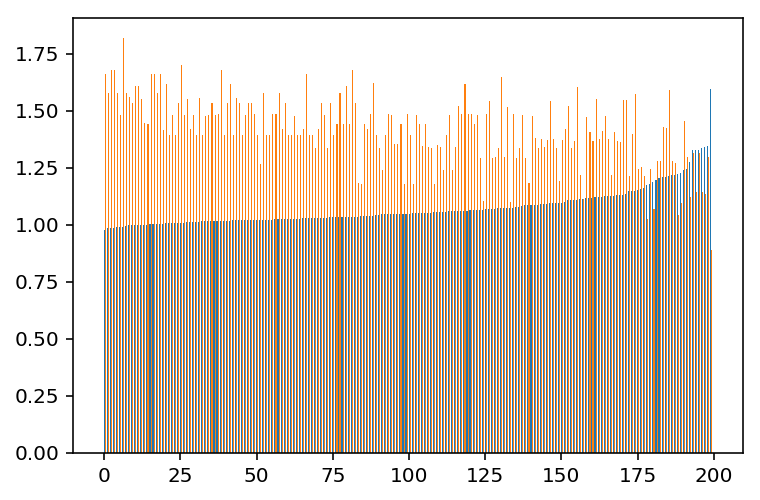

In [45]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

ind = np.arange(len(df))
width = 0.35

plt.bar(ind, df['rmse'], width)
plt.bar(ind + width, df['std_dev'], width)
plt.show()

In [12]:
dataset.titles = {}
for work_id, title in Work.objects.values_list('id', 'title'):
    dataset.titles[work_id] = title

In [20]:
sorted([key, dataset.titles[dataset.decode_work[key]], truth[key]] for key in truth.keys())[:15]

[[13, 'Death Note', 2.0],
 [53, 'Berry Dynamite', 2.0],
 [74, 'Magi - The Labyrinth of Magic', 2.0],
 [242, 'Naruto', 0.10000000000000001],
 [364, 'Gourmet solitaire (le)', 2.0],
 [400, 'Tokyo ghoul', 2.0],
 [445, '20th century boys', 0.10000000000000001],
 [449, 'Lost Paradise', 0.10000000000000001],
 [517, 'Monster', 2.0],
 [571, 'Acid Town', 0.5],
 [588, 'Nausicaa', 2.0],
 [704, 'Bride Stories', 2.0],
 [716, "Vision d'Escaflowne", 0.10000000000000001],
 [717, 'Bamboo Blade', 0.5],
 [718, 'To Love', -2.0]]

In [98]:
dataset.anonymized.X

array([[ 852, 5546],
       [1596, 8593],
       [1036, 6178],
       ..., 
       [ 426,  401],
       [1139, 5611],
       [ 665, 9257]])